In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import torch

DATASET_NAME = 'CIFAR10'    # CIFAR10, CIFAR100
DATASET_TYPE = 'custom'   # baseline, custom
REWEIGHT = True
EPOCHS = 200
BATCH_SIZE = 128
ENABLE_TPU = True
LEARNING_RATE = 0.1   # 0.15(default), 0.1
MANUAL_SEED = 1

# CIFAR-10-C
if DATASET_NAME=='CIFAR10':
    dataset_dir = '/kaggle/input/cifar-c'
    print(os.listdir(dataset_dir))
    # Define the path to the subdirectory
    sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
    # List contents of the subdirectory
    print(os.listdir(sub_dir))
elif DATASET_NAME=='CIFAR100':
    # CIFAR-100-C
    dataset_dir = '/kaggle/input/cifar-100-c'
    print(os.listdir(dataset_dir))
else:
    raise ValueError(f'Dataset {DATASET_NAME} not supported')
    

print(f'Hyperparameters:\n\tDataset: {DATASET_NAME}\n\tType: {DATASET_TYPE}\n\tEpochs: {EPOCHS}\n\tTPU Enabled: {ENABLE_TPU}')

['CIFAR-10-C']
['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']
Hyperparameters:
	Dataset: CIFAR10
	Type: custom
	Epochs: 200
	TPU Enabled: True


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/926.4 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 13.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 3547, done.


remote: Counting objects: 100% (361/361), done.


remote: Compressing objects: 100% (188/188), done.


remote: Total 3547 (delta 201), reused 327 (delta 173), pack-reused 3186 (from 1)
Receiving objects: 100% (3547/3547), 1.10 GiB | 43.85 MiB/s, done.


Resolving deltas: 100% (1956/1956), done.


Updating files: 100% (295/295), done.


In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(MANUAL_SEED)

In [4]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = ENABLE_TPU

if tpu == True:
    print('TPU is Enabled')
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = BATCH_SIZE

print(f'Loading {DATASET_NAME}...\n')
if DATASET_NAME=='CIFAR10':
#     Use CIFAR-10 dataset for training
    num_classes = 10    # CIFAR-10
    baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)

    # Use CIFAR-10 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
elif DATASET_NAME=='CIFAR100':
    # # Use CIFAR-100 dataset for training
    num_classes = 100   # CIFAR-100
    baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)

    # Use CIFAR-100 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
    
%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
# from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True, dataset_name=DATASET_NAME)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation, dataset_name=DATASET_NAME)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
%cd

classes = baseline_trainset.classes


TPU is Enabled


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


Loading CIFAR10...



E0000 00:00:1731590304.804709      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:483


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 458752/170498071 [00:00<00:40, 4155507.36it/s]

  3%|▎         | 4423680/170498071 [00:00<00:06, 24054071.93it/s]

  5%|▌         | 8847360/170498071 [00:00<00:04, 32933403.72it/s]

  7%|▋         | 12222464/170498071 [00:00<00:05, 31322324.00it/s]

  9%|▉         | 15597568/170498071 [00:00<00:04, 32006795.57it/s]

 11%|█         | 19038208/170498071 [00:00<00:04, 32707912.10it/s]

 13%|█▎        | 22347776/170498071 [00:00<00:04, 32382240.95it/s]

 15%|█▌        | 25624576/170498071 [00:00<00:04, 32367215.23it/s]

 17%|█▋        | 28901376/170498071 [00:00<00:04, 31616104.45it/s]

 19%|█▉        | 32079872/170498071 [00:01<00:04, 31401001.52it/s]

 21%|██        | 35258368/170498071 [00:01<00:04, 29430797.35it/s]

 23%|██▎       | 38469632/170498071 [00:01<00:04, 30063733.11it/s]

 24%|██▍       | 41517056/170498071 [00:01<00:04, 27578600.91it/s]

 26%|██▌       | 44335104/170498071 [00:01<00:04, 26976161.50it/s]

 28%|██▊       | 47087616/170498071 [00:01<00:04, 26948174.44it/s]

 29%|██▉       | 49807360/170498071 [00:01<00:04, 26192551.24it/s]

 31%|███▏      | 53411840/170498071 [00:01<00:04, 28882308.97it/s]

 33%|███▎      | 56360960/170498071 [00:01<00:04, 26010639.12it/s]

 35%|███▌      | 59932672/170498071 [00:02<00:03, 28536032.79it/s]

 37%|███▋      | 62881792/170498071 [00:02<00:03, 27234752.35it/s]

 39%|███▊      | 65667072/170498071 [00:02<00:03, 26907645.10it/s]

 40%|████      | 68419584/170498071 [00:02<00:03, 26293629.02it/s]

 42%|████▏     | 71106560/170498071 [00:02<00:03, 25730412.62it/s]

 44%|████▍     | 74678272/170498071 [00:02<00:03, 28456704.00it/s]

 45%|████▌     | 77561856/170498071 [00:02<00:03, 26079534.71it/s]

 47%|████▋     | 80904192/170498071 [00:02<00:03, 27807107.62it/s]

 49%|████▉     | 83755008/170498071 [00:02<00:03, 26904584.52it/s]

 51%|█████     | 86835200/170498071 [00:03<00:03, 27840079.20it/s]

 53%|█████▎    | 89686016/170498071 [00:03<00:02, 27717769.95it/s]

 54%|█████▍    | 92504064/170498071 [00:03<00:02, 26725271.50it/s]

 56%|█████▌    | 95518720/170498071 [00:03<00:02, 27516037.70it/s]

 58%|█████▊    | 98304000/170498071 [00:03<00:02, 26021241.78it/s]

 60%|█████▉    | 101711872/170498071 [00:03<00:02, 28200591.02it/s]

 61%|██████▏   | 104595456/170498071 [00:03<00:02, 26464104.64it/s]

 64%|██████▍   | 108822528/170498071 [00:03<00:02, 30786604.00it/s]

 66%|██████▌   | 112099328/170498071 [00:03<00:01, 31315821.17it/s]

 68%|██████▊   | 115802112/170498071 [00:04<00:01, 32899405.22it/s]

 70%|███████   | 119570432/170498071 [00:04<00:01, 34105485.75it/s]

 72%|███████▏  | 123142144/170498071 [00:04<00:01, 34541877.88it/s]

 75%|███████▍  | 127500288/170498071 [00:04<00:01, 37167452.61it/s]

 77%|███████▋  | 131268608/170498071 [00:04<00:01, 34509395.39it/s]

 79%|███████▉  | 134774784/170498071 [00:04<00:01, 32488066.08it/s]

 81%|████████  | 138084352/170498071 [00:04<00:01, 30000774.52it/s]

 83%|████████▎ | 141164544/170498071 [00:04<00:00, 29904522.71it/s]

 85%|████████▍ | 144211968/170498071 [00:04<00:00, 29430734.01it/s]

 86%|████████▋ | 147193856/170498071 [00:05<00:00, 28925809.57it/s]

 88%|████████▊ | 150110208/170498071 [00:05<00:00, 28547756.13it/s]

 90%|████████▉ | 152993792/170498071 [00:05<00:00, 28036690.63it/s]

 92%|█████████▏| 157155328/170498071 [00:05<00:00, 31854358.23it/s]

 95%|█████████▌| 162332672/170498071 [00:05<00:00, 37538445.38it/s]

 98%|█████████▊| 167804928/170498071 [00:05<00:00, 42395780.88it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 30351620.01it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 458752/170498071 [00:00<00:40, 4169862.12it/s]

  4%|▍         | 7143424/170498071 [00:00<00:04, 39562668.80it/s]

 10%|█         | 17301504/170498071 [00:00<00:02, 67207277.18it/s]

 16%|█▌        | 27557888/170498071 [00:00<00:01, 80920364.97it/s]

 22%|██▏       | 38109184/170498071 [00:00<00:01, 89691179.96it/s]

 28%|██▊       | 48234496/170498071 [00:00<00:01, 93535576.41it/s]

 34%|███▍      | 58392576/170498071 [00:00<00:01, 96009383.56it/s]

 41%|████      | 69107712/170498071 [00:00<00:01, 99434562.19it/s]

 46%|████▋     | 79167488/170498071 [00:00<00:00, 99785932.53it/s]

 52%|█████▏    | 89456640/170498071 [00:01<00:00, 100724926.70it/s]

 59%|█████▊    | 100106240/170498071 [00:01<00:00, 102394069.56it/s]

 65%|██████▍   | 110362624/170498071 [00:01<00:00, 102037339.51it/s]

 71%|███████   | 120717312/170498071 [00:01<00:00, 102423660.08it/s]

 77%|███████▋  | 131497984/170498071 [00:01<00:00, 103993694.02it/s]

 83%|████████▎ | 141918208/170498071 [00:01<00:00, 103396196.74it/s]

 89%|████████▉ | 152272896/170498071 [00:01<00:00, 103194260.29it/s]

 96%|█████████▌| 163053568/170498071 [00:01<00:00, 104561247.26it/s]

100%|██████████| 170498071/170498071 [00:01<00:00, 95250384.46it/s] 

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 458752/170498071 [00:00<00:40, 4149914.81it/s]

  4%|▎         | 6160384/170498071 [00:00<00:04, 33892049.29it/s]

  8%|▊         | 14090240/170498071 [00:00<00:02, 53782135.69it/s]

 13%|█▎        | 22183936/170498071 [00:00<00:02, 64239444.68it/s]

 18%|█▊        | 30015488/170498071 [00:00<00:02, 69124445.70it/s]

 22%|██▏       | 37978112/170498071 [00:00<00:01, 72456373.10it/s]

 27%|██▋       | 45809664/170498071 [00:00<00:01, 74315090.73it/s]

 32%|███▏      | 53936128/170498071 [00:00<00:01, 76512134.75it/s]

 36%|███▌      | 61767680/170498071 [00:00<00:01, 77039421.98it/s]

 41%|████      | 69500928/170498071 [00:01<00:01, 76897296.31it/s]

 45%|████▌     | 77201408/170498071 [00:01<00:01, 76261762.99it/s]

 50%|████▉     | 84836352/170498071 [00:01<00:01, 75540978.91it/s]

 54%|█████▍    | 92405760/170498071 [00:01<00:01, 75106903.54it/s]

 59%|█████▊    | 100139008/170498071 [00:01<00:00, 75768162.08it/s]

 63%|██████▎   | 108134400/170498071 [00:01<00:00, 76958927.49it/s]

 68%|██████▊   | 116129792/170498071 [00:01<00:00, 77812608.71it/s]

 73%|███████▎  | 123928576/170498071 [00:01<00:00, 77462889.05it/s]

 77%|███████▋  | 131989504/170498071 [00:01<00:00, 78386629.34it/s]

 82%|████████▏ | 139853824/170498071 [00:01<00:00, 78117170.03it/s]

 87%|████████▋ | 147685376/170498071 [00:02<00:00, 78115526.87it/s]

 91%|█████████ | 155516928/170498071 [00:02<00:00, 77983577.98it/s]

 96%|█████████▌| 163479552/170498071 [00:02<00:00, 78434442.44it/s]

100%|██████████| 170498071/170498071 [00:02<00:00, 73457508.07it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
    CustomTrivialAugmentWide(custom=True, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
)


Dataset type "custom" displaying...



airplane: 0.50, 0 dog  : 0.90, 5 deer : 0.99, 4 deer : 0.56, 4 truck: 0.70, 9 cat  : 0.81, 3 truck: 0.93, 9 truck: 0.59, 9 cat  : 0.96, 3 cat  : 0.85, 3 airplane: 0.98, 0 horse: 0.98, 7 airplane: 1.00, 0 dog  : 0.83, 5 dog  : 0.90, 5 deer : 0.94, 4 automobile: 0.98, 1 automobile: 0.87, 1 frog : 0.91, 6 automobile: 0.65, 1 frog : 0.87, 6 dog  : 0.77, 5 ship : 0.96, 8 cat  : 0.96, 3 automobile: 0.81, 1 frog : 1.00, 6 deer : 0.77, 4 bird : 0.50, 2 deer : 1.00, 4 bird : 0.97, 2 cat  : 0.62, 3 horse: 1.00, 7 automobile: 1.00, 1 cat  : 0.70, 3 cat  : 0.96, 3 ship : 0.95, 8 horse: 0.99, 7 airplane: 1.00, 0 airplane: 1.00, 0 airplane: 0.93, 0 truck: 0.81, 9 airplane: 0.67, 0 frog : 0.99, 6 horse: 0.70, 7 ship : 1.00, 8 deer : 1.00, 4 bird : 1.00, 2 airplane: 1.00, 0 cat  : 0.99, 3 dog  : 1.00, 5 bird : 0.95, 2 truck: 0.93, 9 dog  : 0.98, 5 cat  : 0.85, 3 deer : 0.59, 4 dog  : 1.00, 5 dog  : 0.90, 5 frog : 0.65, 6 horse: 0.88, 7 frog : 1.00, 6 ship : 0.70, 8 deer : 0.87, 4 airplane: 0.56, 0 tru

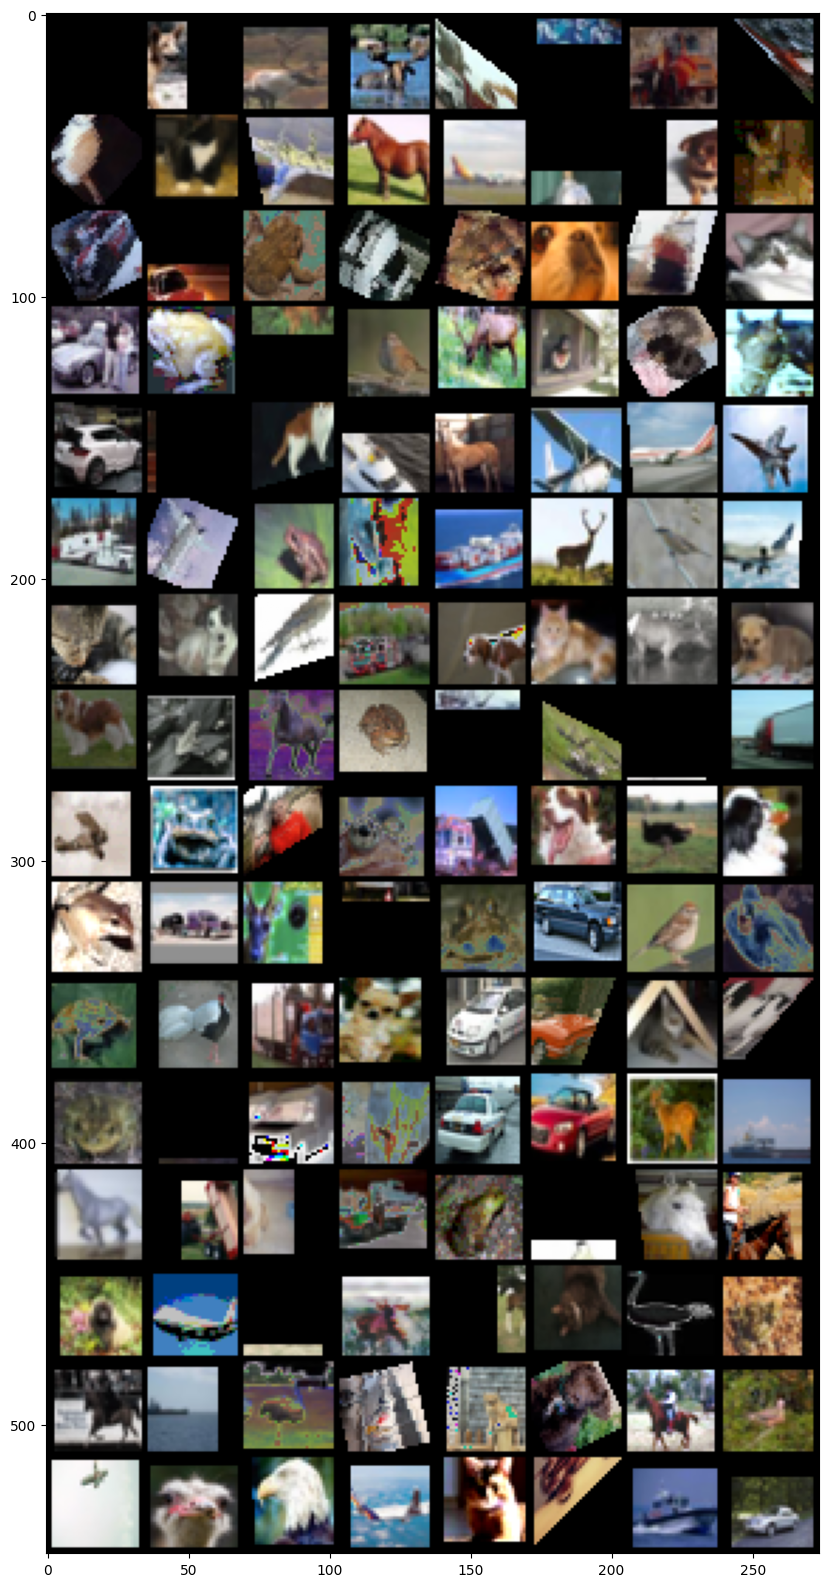

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(25, 20))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
print(f'Dataset type "{DATASET_TYPE}" displaying...\n')

if DATASET_TYPE=='custom':
    dataiter = iter(custom_trainloader)
    images, labels, confidences = next(dataiter)
    # print labels 
    if isinstance(confidences, list):
        # in case we have confidence 
        confidences = confidences[1]
        
    print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}, {labels[j].item()}' for j in range(batch_size)))
elif DATASET_TYPE=='baseline':
#     if training baseline model
    dataiter = iter(baseline_trainloader)
    images, labels = next(dataiter)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
else:
    raise ValueError(f'Dataset type {DATASET_TYPE} not supported')
    
# show images
imshow(torchvision.utils.make_grid(images))

## Define WideResNet 28_4

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

## Model Training

In [9]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [10]:
def soft_loss(pred, label, confidence, reweight=False):
    log_prob = F.log_softmax(pred, dim=1)
    n_class = pred.size(1)

    # Make soft one-hot target
    label = label.unsqueeze(1)
    confidence = confidence.unsqueeze(1).float()
    # soft one_hot
    one_hot = torch.ones_like(pred) * (1 - confidence) / (n_class - 1)
    one_hot.scatter_(dim=1, index=label, src=confidence)
    
    # hard one_hot
#     one_hot = torch.zeros_like(pred)
#     one_hot.scatter_(dim=1, index=label, value=1.0)
    # Compute weighted KL loss
    kl = F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)
    kl = kl.unsqueeze(1)  # Unweighted
    if reweight:
        kl = confidence * kl  # Weighted
    return kl.mean()

In [11]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_accuracies = [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    confidences = None
    
    net.train()
    
    if DATASET_TYPE=='baseline':
        trainloader = baseline_trainloader
    elif DATASET_TYPE=='custom':
        trainloader = custom_trainloader
    else:
        raise ValueError('Dataset type is not Valid!')
    
    for i, data in enumerate(trainloader):
            
        if DATASET_TYPE=='baseline':
            inputs, labels = data
        elif DATASET_TYPE=='custom':
            inputs, labels, confidences = data
            # get the inputs
            """when the model returns [augmentation_magnitude, confidence_aa], which is the case
            only when TA with soft labels is applied."""
            if isinstance(confidences, list):
                confidences = confidences[1]
            confidences = confidences.to(device)
        else:
            raise ValueError('Dataset type is not Valid!')
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
        # labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.to(device)
        
        if DATASET_TYPE=='custom':
            loss = soft_loss(pred=outputs, label=labels, confidence=confidences, reweight=REWEIGHT)
        else:
            loss = criterion(outputs, labels)
        
        # Check for correct training
        if np.isnan(loss.detach().cpu().numpy()):
            raise ValueError('Loss calculation not correct')
    
        loss.backward()
        optimizer.step()
        
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_loss)
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * test_accuracy: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/{DATASET_NAME}_net_ta_{DATASET_TYPE}_{epochs}.pth'
torch.save(net.state_dict(), PATH)


Start Training...



/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: aten::kl_div: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch 1 - Loss: 1.289 - Test Accuracy:  39.450

Processing time:  76.242611 seconds.



Epoch 2 - Loss: 1.025 - Test Accuracy:  44.560

Processing time:  48.838338 seconds.



Epoch 3 - Loss: 0.891 - Test Accuracy:  59.530

Processing time:  36.495113 seconds.



Epoch 4 - Loss: 0.808 - Test Accuracy:  63.750

Processing time:  35.668981 seconds.



Epoch 5 - Loss: 0.733 - Test Accuracy:  64.020

Processing time:  35.645465 seconds.



Epoch 6 - Loss: 0.682 - Test Accuracy:  64.180

Processing time:  36.355817 seconds.



Epoch 7 - Loss: 0.639 - Test Accuracy:  74.730

Processing time:  36.798228 seconds.



Epoch 8 - Loss: 0.608 - Test Accuracy:  71.970

Processing time:  36.580399 seconds.



Epoch 9 - Loss: 0.581 - Test Accuracy:  76.540

Processing time:  36.258158 seconds.



Epoch 10 - Loss: 0.553 - Test Accuracy:  79.800

Processing time:  35.643064 seconds.



Epoch 11 - Loss: 0.538 - Test Accuracy:  79.440

Processing time:  36.266138 seconds.



Epoch 12 - Loss: 0.518 - Test Accuracy:  80.510

Processing time:  35.582002 seconds.



Epoch 13 - Loss: 0.506 - Test Accuracy:  84.070

Processing time:  35.268488 seconds.



Epoch 14 - Loss: 0.488 - Test Accuracy:  79.540

Processing time:  35.455649 seconds.



Epoch 15 - Loss: 0.478 - Test Accuracy:  82.940

Processing time:  34.980139 seconds.



Epoch 16 - Loss: 0.468 - Test Accuracy:  82.460

Processing time:  34.746345 seconds.



Epoch 17 - Loss: 0.453 - Test Accuracy:  81.370

Processing time:  35.110236 seconds.



Epoch 18 - Loss: 0.444 - Test Accuracy:  75.730

Processing time:  36.722728 seconds.



Epoch 19 - Loss: 0.434 - Test Accuracy:  84.040

Processing time:  36.484550 seconds.



Epoch 20 - Loss: 0.430 - Test Accuracy:  85.220

Processing time:  36.255571 seconds.



Epoch 21 - Loss: 0.422 - Test Accuracy:  80.860

Processing time:  35.702375 seconds.



Epoch 22 - Loss: 0.417 - Test Accuracy:  86.700

Processing time:  35.855096 seconds.



Epoch 23 - Loss: 0.410 - Test Accuracy:  86.060

Processing time:  35.713136 seconds.



Epoch 24 - Loss: 0.405 - Test Accuracy:  86.460

Processing time:  35.514049 seconds.



Epoch 25 - Loss: 0.401 - Test Accuracy:  87.660

Processing time:  36.197894 seconds.



Epoch 26 - Loss: 0.400 - Test Accuracy:  87.580

Processing time:  35.413477 seconds.



Epoch 27 - Loss: 0.392 - Test Accuracy:  83.760

Processing time:  35.618303 seconds.



Epoch 28 - Loss: 0.385 - Test Accuracy:  84.510

Processing time:  34.818331 seconds.



Epoch 29 - Loss: 0.385 - Test Accuracy:  86.630

Processing time:  34.878695 seconds.



Epoch 30 - Loss: 0.378 - Test Accuracy:  86.730

Processing time:  34.714874 seconds.



Epoch 31 - Loss: 0.378 - Test Accuracy:  88.250

Processing time:  36.540860 seconds.



Epoch 32 - Loss: 0.371 - Test Accuracy:  88.830

Processing time:  36.263962 seconds.



Epoch 33 - Loss: 0.368 - Test Accuracy:  88.230

Processing time:  34.992187 seconds.



Epoch 34 - Loss: 0.367 - Test Accuracy:  86.680

Processing time:  36.835105 seconds.



Epoch 35 - Loss: 0.367 - Test Accuracy:  84.090

Processing time:  35.740654 seconds.



Epoch 36 - Loss: 0.363 - Test Accuracy:  89.920

Processing time:  35.864289 seconds.



Epoch 37 - Loss: 0.357 - Test Accuracy:  86.980

Processing time:  35.703130 seconds.



Epoch 38 - Loss: 0.355 - Test Accuracy:  90.110

Processing time:  36.065547 seconds.



Epoch 39 - Loss: 0.352 - Test Accuracy:  89.320

Processing time:  36.304497 seconds.



Epoch 40 - Loss: 0.348 - Test Accuracy:  87.520

Processing time:  35.881284 seconds.



Epoch 41 - Loss: 0.347 - Test Accuracy:  89.080

Processing time:  35.140807 seconds.



Epoch 42 - Loss: 0.345 - Test Accuracy:  88.810

Processing time:  35.068648 seconds.



Epoch 43 - Loss: 0.342 - Test Accuracy:  89.620

Processing time:  36.604317 seconds.



Epoch 44 - Loss: 0.346 - Test Accuracy:  86.730

Processing time:  36.068745 seconds.



Epoch 45 - Loss: 0.341 - Test Accuracy:  89.290

Processing time:  36.373407 seconds.



Epoch 46 - Loss: 0.336 - Test Accuracy:  89.350

Processing time:  36.085220 seconds.



Epoch 47 - Loss: 0.334 - Test Accuracy:  88.930

Processing time:  37.125317 seconds.



Epoch 48 - Loss: 0.334 - Test Accuracy:  90.710

Processing time:  36.189863 seconds.



Epoch 49 - Loss: 0.332 - Test Accuracy:  90.090

Processing time:  36.514122 seconds.



Epoch 50 - Loss: 0.324 - Test Accuracy:  89.760

Processing time:  36.816123 seconds.



Epoch 51 - Loss: 0.325 - Test Accuracy:  90.110

Processing time:  36.016491 seconds.



Epoch 52 - Loss: 0.327 - Test Accuracy:  91.040

Processing time:  35.586729 seconds.



Epoch 53 - Loss: 0.323 - Test Accuracy:  87.350

Processing time:  35.780759 seconds.



Epoch 54 - Loss: 0.320 - Test Accuracy:  90.660

Processing time:  35.054665 seconds.



Epoch 55 - Loss: 0.320 - Test Accuracy:  89.620

Processing time:  35.410949 seconds.



Epoch 56 - Loss: 0.315 - Test Accuracy:  89.750

Processing time:  35.556484 seconds.



Epoch 57 - Loss: 0.314 - Test Accuracy:  89.060

Processing time:  36.672019 seconds.



Epoch 58 - Loss: 0.316 - Test Accuracy:  89.690

Processing time:  35.660816 seconds.



Epoch 59 - Loss: 0.311 - Test Accuracy:  89.970

Processing time:  36.030293 seconds.



Epoch 60 - Loss: 0.312 - Test Accuracy:  90.050

Processing time:  36.194639 seconds.



Epoch 61 - Loss: 0.303 - Test Accuracy:  90.830

Processing time:  36.028273 seconds.



Epoch 62 - Loss: 0.305 - Test Accuracy:  90.320

Processing time:  36.894858 seconds.



Epoch 63 - Loss: 0.306 - Test Accuracy:  90.350

Processing time:  35.953208 seconds.



Epoch 64 - Loss: 0.305 - Test Accuracy:  91.560

Processing time:  36.223186 seconds.



Epoch 65 - Loss: 0.305 - Test Accuracy:  90.820

Processing time:  36.103768 seconds.



Epoch 66 - Loss: 0.299 - Test Accuracy:  91.190

Processing time:  36.512819 seconds.



Epoch 67 - Loss: 0.299 - Test Accuracy:  92.130

Processing time:  35.035882 seconds.



Epoch 68 - Loss: 0.296 - Test Accuracy:  91.810

Processing time:  36.189272 seconds.



Epoch 69 - Loss: 0.298 - Test Accuracy:  90.440

Processing time:  34.781496 seconds.



Epoch 70 - Loss: 0.293 - Test Accuracy:  89.860

Processing time:  35.281967 seconds.



Epoch 71 - Loss: 0.294 - Test Accuracy:  90.820

Processing time:  34.785682 seconds.



Epoch 72 - Loss: 0.296 - Test Accuracy:  91.380

Processing time:  35.159938 seconds.



Epoch 73 - Loss: 0.288 - Test Accuracy:  90.020

Processing time:  35.875237 seconds.



Epoch 74 - Loss: 0.289 - Test Accuracy:  90.790

Processing time:  36.399557 seconds.



Epoch 75 - Loss: 0.285 - Test Accuracy:  92.100

Processing time:  36.238633 seconds.



Epoch 76 - Loss: 0.283 - Test Accuracy:  91.300

Processing time:  35.774938 seconds.



Epoch 77 - Loss: 0.288 - Test Accuracy:  91.330

Processing time:  35.402390 seconds.



Epoch 78 - Loss: 0.280 - Test Accuracy:  89.300

Processing time:  35.949957 seconds.



Epoch 79 - Loss: 0.280 - Test Accuracy:  90.260

Processing time:  36.459460 seconds.



Epoch 80 - Loss: 0.280 - Test Accuracy:  91.700

Processing time:  35.632558 seconds.



Epoch 81 - Loss: 0.276 - Test Accuracy:  90.540

Processing time:  35.122427 seconds.



Epoch 82 - Loss: 0.279 - Test Accuracy:  92.020

Processing time:  35.176305 seconds.



Epoch 83 - Loss: 0.276 - Test Accuracy:  90.820

Processing time:  35.744518 seconds.



Epoch 84 - Loss: 0.272 - Test Accuracy:  90.790

Processing time:  36.165313 seconds.



Epoch 85 - Loss: 0.262 - Test Accuracy:  91.180

Processing time:  36.393971 seconds.



Epoch 86 - Loss: 0.270 - Test Accuracy:  91.990

Processing time:  35.175985 seconds.



Epoch 87 - Loss: 0.267 - Test Accuracy:  91.420

Processing time:  35.007452 seconds.



Epoch 88 - Loss: 0.264 - Test Accuracy:  92.300

Processing time:  35.204079 seconds.



Epoch 89 - Loss: 0.262 - Test Accuracy:  92.420

Processing time:  35.549714 seconds.



Epoch 90 - Loss: 0.263 - Test Accuracy:  89.750

Processing time:  36.583767 seconds.



Epoch 91 - Loss: 0.266 - Test Accuracy:  91.650

Processing time:  34.813682 seconds.



Epoch 92 - Loss: 0.261 - Test Accuracy:  91.440

Processing time:  35.405532 seconds.



Epoch 93 - Loss: 0.262 - Test Accuracy:  92.600

Processing time:  34.636992 seconds.



Epoch 94 - Loss: 0.260 - Test Accuracy:  91.800

Processing time:  34.698681 seconds.



Epoch 95 - Loss: 0.254 - Test Accuracy:  92.760

Processing time:  36.647171 seconds.



Epoch 96 - Loss: 0.252 - Test Accuracy:  92.510

Processing time:  35.303223 seconds.



Epoch 97 - Loss: 0.253 - Test Accuracy:  91.070

Processing time:  37.221516 seconds.



Epoch 98 - Loss: 0.251 - Test Accuracy:  92.520

Processing time:  36.107688 seconds.



Epoch 99 - Loss: 0.246 - Test Accuracy:  91.650

Processing time:  36.163568 seconds.



Epoch 100 - Loss: 0.248 - Test Accuracy:  90.710

Processing time:  36.418362 seconds.



Epoch 101 - Loss: 0.244 - Test Accuracy:  93.260

Processing time:  35.616595 seconds.



Epoch 102 - Loss: 0.244 - Test Accuracy:  92.690

Processing time:  36.628003 seconds.



Epoch 103 - Loss: 0.244 - Test Accuracy:  91.830

Processing time:  36.262817 seconds.



Epoch 104 - Loss: 0.242 - Test Accuracy:  93.020

Processing time:  36.237938 seconds.



Epoch 105 - Loss: 0.240 - Test Accuracy:  92.890

Processing time:  35.357605 seconds.



Epoch 106 - Loss: 0.240 - Test Accuracy:  93.240

Processing time:  36.333599 seconds.



Epoch 107 - Loss: 0.238 - Test Accuracy:  93.990

Processing time:  35.858388 seconds.



Epoch 108 - Loss: 0.235 - Test Accuracy:  93.200

Processing time:  36.142050 seconds.



Epoch 109 - Loss: 0.232 - Test Accuracy:  93.190

Processing time:  36.182300 seconds.



Epoch 110 - Loss: 0.231 - Test Accuracy:  93.840

Processing time:  36.335829 seconds.



Epoch 111 - Loss: 0.229 - Test Accuracy:  93.300

Processing time:  35.921710 seconds.



Epoch 112 - Loss: 0.232 - Test Accuracy:  93.840

Processing time:  35.456248 seconds.



Epoch 113 - Loss: 0.228 - Test Accuracy:  93.340

Processing time:  34.917495 seconds.



Epoch 114 - Loss: 0.225 - Test Accuracy:  92.490

Processing time:  35.436220 seconds.



Epoch 115 - Loss: 0.221 - Test Accuracy:  93.970

Processing time:  34.691113 seconds.



Epoch 116 - Loss: 0.222 - Test Accuracy:  94.060

Processing time:  35.237716 seconds.



Epoch 117 - Loss: 0.221 - Test Accuracy:  92.630

Processing time:  35.855260 seconds.



Epoch 118 - Loss: 0.221 - Test Accuracy:  93.540

Processing time:  34.709401 seconds.



Epoch 119 - Loss: 0.215 - Test Accuracy:  93.270

Processing time:  34.753142 seconds.



Epoch 120 - Loss: 0.215 - Test Accuracy:  94.060

Processing time:  36.014640 seconds.



Epoch 121 - Loss: 0.212 - Test Accuracy:  93.920

Processing time:  35.728143 seconds.



Epoch 122 - Loss: 0.213 - Test Accuracy:  93.940

Processing time:  35.518982 seconds.



Epoch 123 - Loss: 0.207 - Test Accuracy:  94.200

Processing time:  35.963215 seconds.



Epoch 124 - Loss: 0.208 - Test Accuracy:  94.460

Processing time:  35.263527 seconds.



Epoch 125 - Loss: 0.207 - Test Accuracy:  94.380

Processing time:  35.037261 seconds.



Epoch 126 - Loss: 0.205 - Test Accuracy:  94.260

Processing time:  35.657362 seconds.



Epoch 127 - Loss: 0.203 - Test Accuracy:  94.670

Processing time:  35.198161 seconds.



Epoch 128 - Loss: 0.199 - Test Accuracy:  94.010

Processing time:  36.213031 seconds.



Epoch 129 - Loss: 0.203 - Test Accuracy:  94.080

Processing time:  35.834941 seconds.



Epoch 130 - Loss: 0.200 - Test Accuracy:  94.000

Processing time:  35.539111 seconds.



Epoch 131 - Loss: 0.196 - Test Accuracy:  94.280

Processing time:  35.551673 seconds.



Epoch 132 - Loss: 0.195 - Test Accuracy:  94.020

Processing time:  35.965328 seconds.



Epoch 133 - Loss: 0.193 - Test Accuracy:  94.210

Processing time:  34.894649 seconds.



Epoch 134 - Loss: 0.191 - Test Accuracy:  94.830

Processing time:  36.625547 seconds.



Epoch 135 - Loss: 0.191 - Test Accuracy:  94.100

Processing time:  36.043409 seconds.



Epoch 136 - Loss: 0.189 - Test Accuracy:  94.590

Processing time:  35.685240 seconds.



Epoch 137 - Loss: 0.187 - Test Accuracy:  94.970

Processing time:  36.022514 seconds.



Epoch 138 - Loss: 0.186 - Test Accuracy:  94.630

Processing time:  36.024095 seconds.



Epoch 139 - Loss: 0.185 - Test Accuracy:  94.770

Processing time:  35.760356 seconds.



Epoch 140 - Loss: 0.181 - Test Accuracy:  94.960

Processing time:  35.710090 seconds.



Epoch 141 - Loss: 0.182 - Test Accuracy:  94.340

Processing time:  36.260575 seconds.



Epoch 142 - Loss: 0.178 - Test Accuracy:  95.360

Processing time:  35.374498 seconds.



Epoch 143 - Loss: 0.174 - Test Accuracy:  95.110

Processing time:  35.815733 seconds.



Epoch 144 - Loss: 0.173 - Test Accuracy:  95.240

Processing time:  35.790812 seconds.



Epoch 145 - Loss: 0.172 - Test Accuracy:  95.200

Processing time:  35.589351 seconds.



Epoch 146 - Loss: 0.172 - Test Accuracy:  95.170

Processing time:  36.212449 seconds.



Epoch 147 - Loss: 0.168 - Test Accuracy:  95.370

Processing time:  36.793295 seconds.



Epoch 148 - Loss: 0.167 - Test Accuracy:  94.690

Processing time:  36.093621 seconds.



Epoch 149 - Loss: 0.168 - Test Accuracy:  95.040

Processing time:  34.855346 seconds.



Epoch 150 - Loss: 0.163 - Test Accuracy:  95.150

Processing time:  37.540213 seconds.



Epoch 151 - Loss: 0.160 - Test Accuracy:  95.270

Processing time:  36.571982 seconds.



Epoch 152 - Loss: 0.161 - Test Accuracy:  95.040

Processing time:  35.076052 seconds.



Epoch 153 - Loss: 0.158 - Test Accuracy:  95.440

Processing time:  34.989915 seconds.



Epoch 154 - Loss: 0.160 - Test Accuracy:  95.620

Processing time:  34.746699 seconds.



Epoch 155 - Loss: 0.154 - Test Accuracy:  95.750

Processing time:  35.909138 seconds.



Epoch 156 - Loss: 0.154 - Test Accuracy:  95.410

Processing time:  34.724366 seconds.



Epoch 157 - Loss: 0.153 - Test Accuracy:  95.540

Processing time:  36.871737 seconds.



Epoch 158 - Loss: 0.151 - Test Accuracy:  95.670

Processing time:  34.758132 seconds.



Epoch 159 - Loss: 0.150 - Test Accuracy:  95.510

Processing time:  34.812524 seconds.



Epoch 160 - Loss: 0.149 - Test Accuracy:  95.630

Processing time:  35.572959 seconds.



Epoch 161 - Loss: 0.146 - Test Accuracy:  95.910

Processing time:  35.624079 seconds.



Epoch 162 - Loss: 0.149 - Test Accuracy:  95.630

Processing time:  34.956484 seconds.



Epoch 163 - Loss: 0.145 - Test Accuracy:  95.790

Processing time:  38.060188 seconds.



Epoch 164 - Loss: 0.143 - Test Accuracy:  95.640

Processing time:  35.937075 seconds.



Epoch 165 - Loss: 0.140 - Test Accuracy:  95.410

Processing time:  35.678932 seconds.



Epoch 166 - Loss: 0.141 - Test Accuracy:  95.840

Processing time:  35.674173 seconds.



Epoch 167 - Loss: 0.139 - Test Accuracy:  95.920

Processing time:  35.753198 seconds.



Epoch 168 - Loss: 0.136 - Test Accuracy:  95.730

Processing time:  34.916171 seconds.



Epoch 169 - Loss: 0.136 - Test Accuracy:  95.790

Processing time:  35.370432 seconds.



Epoch 170 - Loss: 0.135 - Test Accuracy:  95.770

Processing time:  34.781416 seconds.



Epoch 171 - Loss: 0.133 - Test Accuracy:  96.000

Processing time:  36.339681 seconds.



Epoch 172 - Loss: 0.134 - Test Accuracy:  96.200

Processing time:  34.870334 seconds.



Epoch 173 - Loss: 0.133 - Test Accuracy:  96.090

Processing time:  37.278468 seconds.



Epoch 174 - Loss: 0.130 - Test Accuracy:  96.120

Processing time:  35.703211 seconds.



Epoch 175 - Loss: 0.131 - Test Accuracy:  96.060

Processing time:  34.725371 seconds.



Epoch 176 - Loss: 0.129 - Test Accuracy:  96.100

Processing time:  36.964641 seconds.



Epoch 177 - Loss: 0.130 - Test Accuracy:  96.160

Processing time:  35.482226 seconds.



Epoch 178 - Loss: 0.128 - Test Accuracy:  96.180

Processing time:  34.758383 seconds.



Epoch 179 - Loss: 0.128 - Test Accuracy:  96.210

Processing time:  35.730397 seconds.



Epoch 180 - Loss: 0.127 - Test Accuracy:  96.130

Processing time:  35.521845 seconds.



Epoch 181 - Loss: 0.127 - Test Accuracy:  95.970

Processing time:  34.948253 seconds.



Epoch 182 - Loss: 0.126 - Test Accuracy:  96.060

Processing time:  34.826357 seconds.



Epoch 183 - Loss: 0.124 - Test Accuracy:  96.050

Processing time:  36.071183 seconds.



Epoch 184 - Loss: 0.125 - Test Accuracy:  96.140

Processing time:  34.759697 seconds.



Epoch 185 - Loss: 0.124 - Test Accuracy:  96.170

Processing time:  34.920161 seconds.



Epoch 186 - Loss: 0.123 - Test Accuracy:  96.240

Processing time:  36.849480 seconds.



Epoch 187 - Loss: 0.125 - Test Accuracy:  96.240

Processing time:  36.002198 seconds.



Epoch 188 - Loss: 0.123 - Test Accuracy:  96.260

Processing time:  36.043869 seconds.



Epoch 189 - Loss: 0.123 - Test Accuracy:  96.230

Processing time:  35.825470 seconds.



Epoch 190 - Loss: 0.121 - Test Accuracy:  96.260

Processing time:  36.019651 seconds.



Epoch 191 - Loss: 0.121 - Test Accuracy:  96.110

Processing time:  36.051010 seconds.



Epoch 192 - Loss: 0.122 - Test Accuracy:  96.240

Processing time:  36.240539 seconds.



Epoch 193 - Loss: 0.121 - Test Accuracy:  96.170

Processing time:  35.920444 seconds.



Epoch 194 - Loss: 0.120 - Test Accuracy:  96.250

Processing time:  35.634819 seconds.



Epoch 195 - Loss: 0.123 - Test Accuracy:  96.220

Processing time:  36.101600 seconds.



Epoch 196 - Loss: 0.121 - Test Accuracy:  96.210

Processing time:  36.150917 seconds.



Epoch 197 - Loss: 0.121 - Test Accuracy:  96.280

Processing time:  35.741274 seconds.



Epoch 198 - Loss: 0.120 - Test Accuracy:  96.300

Processing time:  35.641314 seconds.



Epoch 199 - Loss: 0.121 - Test Accuracy:  96.260

Processing time:  36.426487 seconds.



Epoch 200 - Loss: 0.118 - Test Accuracy:  96.230

Processing time:  35.937394 seconds.
Finished Training


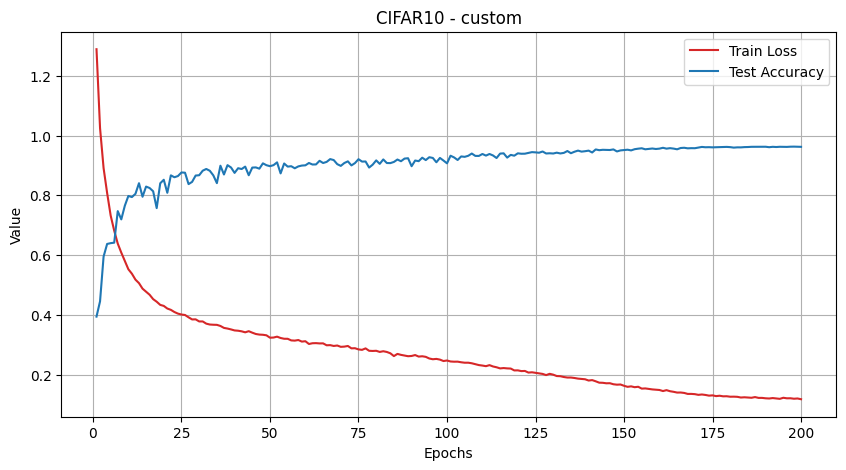

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title(f'{DATASET_NAME} - {DATASET_TYPE}')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the model on Testset

In [13]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        if DATASET_NAME=='CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        elif DATASET_NAME=='CIFAR100':
            np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        else:
            raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
            
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 96.23 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 89.91 %


Accuracy of the network on gaussian_noise dataset split 2: 80.80 %


Accuracy of the network on gaussian_noise dataset split 3: 68.01 %


Accuracy of the network on gaussian_noise dataset split 4: 61.88 %


Accuracy of the network on gaussian_noise dataset split 5: 55.30 %
Average accuracy for gaussian_noise dataset: 71.18 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 92.43 %


Accuracy of the network on shot_noise dataset split 2: 88.53 %


Accuracy of the network on shot_noise dataset split 3: 76.39 %


Accuracy of the network on shot_noise dataset split 4: 70.49 %


Accuracy of the network on shot_noise dataset split 5: 60.86 %
Average accuracy for shot_noise dataset: 77.74 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 94.21 %


Accuracy of the network on impulse_noise dataset split 2: 91.63 %


Accuracy of the network on impulse_noise dataset split 3: 87.92 %


Accuracy of the network on impulse_noise dataset split 4: 74.75 %


Accuracy of the network on impulse_noise dataset split 5: 58.31 %
Average accuracy for impulse_noise dataset: 81.36 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 96.12 %


Accuracy of the network on defocus_blur dataset split 2: 95.20 %


Accuracy of the network on defocus_blur dataset split 3: 93.74 %


Accuracy of the network on defocus_blur dataset split 4: 91.26 %


Accuracy of the network on defocus_blur dataset split 5: 82.61 %
Average accuracy for defocus_blur dataset: 91.79 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 85.11 %


Accuracy of the network on glass_blur dataset split 2: 85.29 %


Accuracy of the network on glass_blur dataset split 3: 85.75 %


Accuracy of the network on glass_blur dataset split 4: 73.13 %


Accuracy of the network on glass_blur dataset split 5: 74.86 %
Average accuracy for glass_blur dataset: 80.83 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 93.95 %


Accuracy of the network on motion_blur dataset split 2: 90.39 %


Accuracy of the network on motion_blur dataset split 3: 84.68 %


Accuracy of the network on motion_blur dataset split 4: 84.18 %


Accuracy of the network on motion_blur dataset split 5: 77.30 %
Average accuracy for motion_blur dataset: 86.10 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 93.21 %


Accuracy of the network on zoom_blur dataset split 2: 92.70 %


Accuracy of the network on zoom_blur dataset split 3: 91.10 %


Accuracy of the network on zoom_blur dataset split 4: 89.18 %


Accuracy of the network on zoom_blur dataset split 5: 84.67 %
Average accuracy for zoom_blur dataset: 90.17 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 94.54 %


Accuracy of the network on snow dataset split 2: 90.92 %


Accuracy of the network on snow dataset split 3: 91.00 %


Accuracy of the network on snow dataset split 4: 88.43 %


Accuracy of the network on snow dataset split 5: 85.70 %
Average accuracy for snow dataset: 90.12 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 94.01 %


Accuracy of the network on frost dataset split 2: 91.69 %


Accuracy of the network on frost dataset split 3: 86.35 %


Accuracy of the network on frost dataset split 4: 85.29 %


Accuracy of the network on frost dataset split 5: 77.94 %
Average accuracy for frost dataset: 87.06 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 96.00 %


Accuracy of the network on fog dataset split 2: 95.54 %


Accuracy of the network on fog dataset split 3: 94.60 %


Accuracy of the network on fog dataset split 4: 92.60 %


Accuracy of the network on fog dataset split 5: 80.99 %
Average accuracy for fog dataset: 91.95 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 96.19 %


Accuracy of the network on brightness dataset split 2: 95.88 %


Accuracy of the network on brightness dataset split 3: 95.50 %


Accuracy of the network on brightness dataset split 4: 95.21 %


Accuracy of the network on brightness dataset split 5: 93.88 %
Average accuracy for brightness dataset: 95.33 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 95.89 %


Accuracy of the network on contrast dataset split 2: 94.55 %


Accuracy of the network on contrast dataset split 3: 93.30 %


Accuracy of the network on contrast dataset split 4: 91.21 %


Accuracy of the network on contrast dataset split 5: 81.35 %
Average accuracy for contrast dataset: 91.26 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 94.00 %


Accuracy of the network on elastic_transform dataset split 2: 93.70 %


Accuracy of the network on elastic_transform dataset split 3: 92.37 %


Accuracy of the network on elastic_transform dataset split 4: 87.74 %


Accuracy of the network on elastic_transform dataset split 5: 83.17 %
Average accuracy for elastic_transform dataset: 90.20 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 94.94 %


Accuracy of the network on pixelate dataset split 2: 91.70 %


Accuracy of the network on pixelate dataset split 3: 87.91 %


Accuracy of the network on pixelate dataset split 4: 70.73 %


Accuracy of the network on pixelate dataset split 5: 49.46 %
Average accuracy for pixelate dataset: 78.95 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 90.62 %


Accuracy of the network on jpeg_compression dataset split 2: 86.49 %


Accuracy of the network on jpeg_compression dataset split 3: 84.65 %


Accuracy of the network on jpeg_compression dataset split 4: 82.74 %


Accuracy of the network on jpeg_compression dataset split 5: 79.49 %
Average accuracy for jpeg_compression dataset: 84.80 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 92.76 %


Accuracy of the network on speckle_noise dataset split 2: 86.23 %


Accuracy of the network on speckle_noise dataset split 3: 82.12 %


Accuracy of the network on speckle_noise dataset split 4: 72.75 %


Accuracy of the network on speckle_noise dataset split 5: 63.41 %
Average accuracy for speckle_noise dataset: 79.45 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 96.15 %


Accuracy of the network on gaussian_blur dataset split 2: 93.69 %


Accuracy of the network on gaussian_blur dataset split 3: 91.48 %


Accuracy of the network on gaussian_blur dataset split 4: 88.34 %


Accuracy of the network on gaussian_blur dataset split 5: 77.50 %
Average accuracy for gaussian_blur dataset: 89.43 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 95.26 %


Accuracy of the network on spatter dataset split 2: 93.36 %


Accuracy of the network on spatter dataset split 3: 90.17 %


Accuracy of the network on spatter dataset split 4: 93.84 %


Accuracy of the network on spatter dataset split 5: 90.56 %
Average accuracy for spatter dataset: 92.64 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 94.78 %


Accuracy of the network on saturate dataset split 2: 92.53 %


Accuracy of the network on saturate dataset split 3: 95.84 %


Accuracy of the network on saturate dataset split 4: 94.54 %


Accuracy of the network on saturate dataset split 5: 92.60 %
Average accuracy for saturate dataset: 94.06 %
Average Robust Accuracy: 86.55 %


In [14]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=num_classes)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/CIFAR10_net_ta_custom_100.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# import torch
# import numpy as np


# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')
        
# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         if DATASET_NAME=='CIFAR10':
#             np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         elif DATASET_NAME=='CIFAR100':
#             np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
#         else:
#             raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")